#### Kaggle: https://www.kaggle.com/c/sai-vessel-segmentation2

test IMAGE_SIZE = 512

In [109]:
!pip install numpy
!pip install albumentations --upgrade


In [110]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import albumentations as A # 主要的圖像增強庫

from sklearn.model_selection import train_test_split
import pandas as pd

import torch
from torch import nn
import torchvision
import torchsummary

torch.__version__, np.__version__ # 檢查版本，確保 NumPy >= 2.0

('2.9.0+cu126', '2.0.2')

In [111]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


#### Download data

In [112]:
# download dataset from https://drive.google.com/file/d/1JILW10sr40CRTLiuA1mf__5GBtMDF9xc/view?usp=sharing
!pip install --upgrade gdown
!gdown --id 1JILW10sr40CRTLiuA1mf__5GBtMDF9xc --output vessel_seg.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1JILW10sr40CRTLiuA1mf__5GBtMDF9xc
From (redirected): https://drive.google.com/uc?id=1JILW10sr40CRTLiuA1mf__5GBtMDF9xc&confirm=t&uuid=8837a090-a013-4a50-adb2-2dfec16f1dab
To: /content/vessel_seg.zip
100% 29.2M/29.2M [00:00<00:00, 172MB/s] 


In [113]:
# unzip file
!unzip -q vessel_seg.zip

replace all/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [114]:
# read img and mask
img_paths = sorted(glob('all/train/*.tif'))
img_path = img_paths[0]
mask_path = img_path.replace('_training.tif', '_manual1.gif')

print('img path: ', img_path)
print('mask path:',  mask_path)

img = cv2.imread(img_path)[:, :, ::-1]
mask = Image.open(mask_path)
mask = np.array(mask)

len(img_paths), len(mask_path)

img path:  all/train/21_training.tif
mask path: all/train/21_manual1.gif


(20, 24)

#### Data Analysis


---

all


*   train/
    *   id1_training.tif
    *   id1**_manual1**.gif
    *   id2_training.tif
    *   id2**_manual1**.gif
    *   ...
*   test/
    *   ...



Image shape: (H, W, C)

*   C: 3 RGB channels

Mask  shape: (H, W)
* 0: background
* 255: vessel

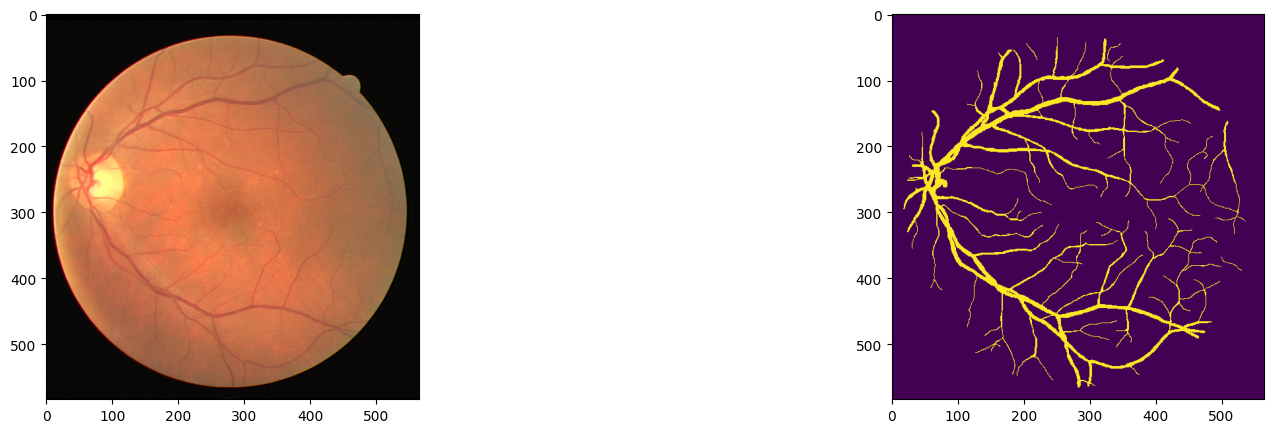

In [115]:
# show image
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

In [116]:
img.shape, mask.shape

((584, 565, 3), (584, 565))

In [117]:
# Calculate tumor pixel
values, counts = np.unique(mask, return_counts=True)
values, counts

(array([  0, 255], dtype=uint8), array([305302,  24658]))

# Dataset & Dataloader


In [118]:
IMG_SIZE = 512
BS = 4

In [119]:
class VesselDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, img_size, mode, augmentation=False):
        """
        mode: str, 'train' 'val' 'test'
        """
        self.img_paths = img_paths
        self.mask_paths = [m_path.replace('training.tif', 'manual1.gif') for m_path in self.img_paths]
        self.img_size = img_size
        self.mode = mode

        self.augmentation = augmentation

        # 使用 Albumentations 定義增強管線 (Augmentation Pipeline)
        # 注意: Albumentations 在初始化時只需定義轉換規則
        self.augmentor = A.Compose([
            A.HorizontalFlip(p=0.5), # 50% horizontal flip (對應 Fliplr(0.5))
            A.Affine(
                rotate=(-45, 45),     # 旋轉 -45 ~ +45 度
                shear=(-16, 16),      # 剪切 -16 ~ +16 度
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # 縮放
                interpolation=cv2.INTER_LINEAR,
                mask_interpolation=cv2.INTER_NEAREST, # 對 Mask 使用最近鄰插值
                p=1 # 總是應用 Affine
            )
        ],
        # 告訴 Albumentations 圖像和遮罩都要同時進行轉換
        additional_targets={'mask': 'mask'})

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]

        # --- 圖像讀取與預處理 ---
        # 圖像讀取: BGR -> RGB
        img = cv2.imread(img_path)[:, :, ::-1]
        img = cv2.resize(img, (self.img_size, self.img_size)) # (IMG_SIZE, IMG_SIZE, 3)
        # Normalize Image (Albumentations 默認要求 0-255，但在此先做也無妨)
        img = img / 255.

        if self.mode != 'test':
            mask_path = self.mask_paths[idx]
            mask = np.array(Image.open(mask_path))
            mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST) # 對 Mask 使用 NEAREST

            # Binarize mask (0~255 -> 0 or 1)
            # 使用 np.uint8 可以節省記憶體，但在 PyTorch 中轉換成 long tensor 時不會有影響
            mask = np.where(mask < 127, 0, 1).astype(np.uint8)

            # --- 圖像增強 (Albumentations) ---
            if self.augmentation:
                # Albumentations 接收並回傳一個字典
                augmented = self.augmentor(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']

            # --- 轉換為 PyTorch Tensor ---
            # 1. 轉換到 PyTorch Tensor
            # 2. 轉換 Channel 順序: (H, W, C) -> (C, H, W)
            # Img: float (0.0~1.0), Mask: long (0 或 1)

            # 如果 img 已經是 0-1 範圍的 float，dtype=torch.float 是正確的
            img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)

            # Albumentations 返回的是 (H, W)，直接轉為 long tensor
            mask = torch.tensor(mask, dtype=torch.long)

            return img, mask
        else:
            # 這是 'test' 模式，只返回圖像
            img_tensor = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
            return img_tensor

In [120]:
all_paths = sorted(glob('all/train/*.tif'))
test_paths = sorted(glob('all/test/*.tif'))
train_paths, val_paths = train_test_split(all_paths, test_size=0.2)

In [121]:
train_ds = VesselDataset(train_paths, IMG_SIZE, 'train', augmentation=True)
val_ds = VesselDataset(val_paths, IMG_SIZE, 'val')
test_ds = VesselDataset(test_paths, IMG_SIZE, 'test')

# https://pytorch.org/docs/stable/data.html
NUM_WORKERS = 0 # > 0 to accelerate loading data by muli-process

train_loader = torch.utils.data.DataLoader(train_ds, BS, shuffle=True, num_workers=NUM_WORKERS)
val_loader = torch.utils.data.DataLoader(val_ds, BS, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_ds, BS)

In [122]:
len(train_ds),len(val_ds), len(test_ds)

(16, 4, 20)

Visulize data

img.shape:  torch.Size([3, 512, 512]) 
mask.shape:  torch.Size([512, 512])


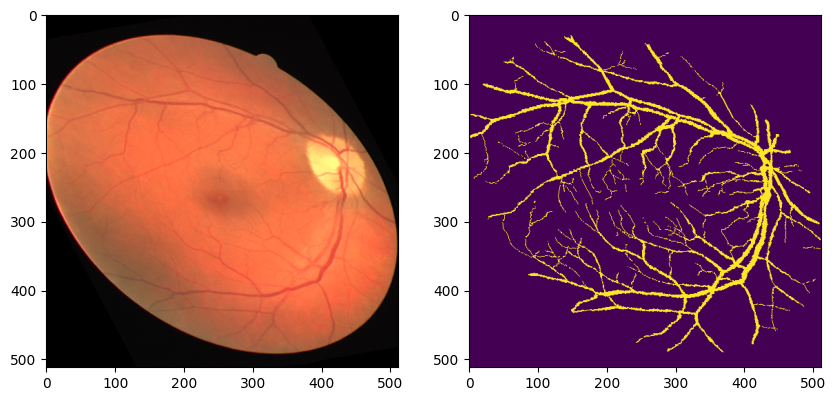

In [123]:
img, mask = train_ds[0] # take 1 data
print('img.shape: ', img.shape, '\nmask.shape: ', mask.shape)
img = img.numpy().transpose(1, 2, 0) # (C, H, W) -> (H, W, C)
mask = mask.numpy().squeeze() # (1, H, W) -> (H, W)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

#### Build Model

In [124]:
# Basic Conv block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def __call__(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()
        # Encoder
        self.encoder1 = ConvBlock(in_channels, init_features) # (3, H, W) -> (32, H, W)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = ConvBlock(init_features, init_features*2) # (32, H/2, W/2) -> (64, H/2, W/2)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = ConvBlock(init_features*2, init_features*4) # (64, H/4, W/4) -> (128, H/4, W/4)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = ConvBlock(init_features*4, init_features*8) # (128, H/8, W/8) -> (256, H/8, W/8)
        self.pool4 = nn.MaxPool2d(2)
        self.encoder5 = ConvBlock(init_features*8, init_features*16) # (256, H/16, W/16) -> (512, H/16, W/16)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(init_features*16, # (512, H/16, W/16) -> (256, H/8, W/8)
                          init_features*8,
                          kernel_size=2, stride=2)
        self.decoder4 = ConvBlock(init_features*8*2, init_features*8)
        self.upconv3 = nn.ConvTranspose2d(init_features*8, # (256, H/8, W/8) -> (128, H/4, W/4)
                          init_features*4,
                          kernel_size=2, stride=2)
        self.decoder3 = ConvBlock(init_features*4*2, init_features*4)
        self.upconv2 = nn.ConvTranspose2d(init_features*4, # (128, H/4, W/4) -> (64, H/2, W/2)
                          init_features*2,
                          kernel_size=2, stride=2)
        self.decoder2 = ConvBlock(init_features*2*2, init_features*2)
        self.upconv1 = nn.ConvTranspose2d(init_features*2, # (62, H/2, W/2) -> (32, H, W)
                          init_features,
                          kernel_size=2, stride=2)
        self.decoder1 = ConvBlock(init_features*2, init_features)
        # Output (head): classification for each pixel, C=2
        self.output = nn.Conv2d(
            init_features,
            out_channels=out_channels,
            kernel_size=1) # (32, H, W) -> (2, H, W)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        bottleneck = self.encoder5(self.pool4(enc4))

        # Decoder
        # (BS, 256, H/8, W/8) + (BS, 256, H/8, W/8) -> (BS, 512, H/8, W/8)
        x = torch.cat((self.upconv4(bottleneck), enc4), dim=1)
        x = self.decoder4(x)

        x = torch.cat((self.upconv3(x), enc3), dim=1)
        x = self.decoder3(x)

        x = torch.cat((self.upconv2(x), enc2), dim=1)
        x = self.decoder2(x)

        x = torch.cat((self.upconv1(x), enc1), dim=1)
        x = self.decoder1(x)

        x = self.output(x)
        return x

In [128]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# build model to GPU
model = UNet(in_channels=3,
             out_channels=2,
             init_features=48).to(device)

cuda


#### Training

In [129]:
# PyTorch Dice loss
!pip install fusionlab

import fusionlab as fl
from fusionlab.losses import DiceLoss, IoULoss
from fusionlab.metrics import DiceScore, IoUScore

dice_score = DiceScore(reduction="mean")

In [130]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train() # to training mode.
    epoch_loss = 0
    epoch_dice = 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        epoch_loss += loss.item() # tensor -> python value
        epoch_dice += dice_score(pred, y).item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_dice/num_batches


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss = 0
    epoch_dice = 0
    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_dice += dice_score(pred, y).item()

    return epoch_loss/num_batches, epoch_dice/num_batches

In [131]:
EPOCHS = 50
logs = {
    'train_loss': [], 'val_loss': [],
    'train_dice': [], 'val_dice': [],
}
# loss_fn = nn.CrossEntropyLoss() # classification for each pixel
loss_fn = fl.losses.DiceLoss("multiclass")
# loss_fn = fl.losses.IoULoss("multiclass")

optimizer = torch.optim.Adam(model.parameters())

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_dice = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_dice = test(val_loader, model, loss_fn)
    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)
    logs['train_dice'].append(train_dice)
    logs['val_dice'].append(val_dice)

    print(f'EPOCH: {epoch:04d} train_loss: {train_loss:.4f} val_loss: {val_loss:.4f}, train_dice: {train_dice:.3f}, val_dice: {val_dice:.3f}')

    # On epoch end
    torch.save(model.state_dict(), "last.pth")
    # check improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0000 train_loss: 0.5947 val_loss: 0.6043, train_dice: 0.405, val_dice: 0.396


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0001 train_loss: 0.5207 val_loss: 0.5874, train_dice: 0.479, val_dice: 0.413


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0002 train_loss: 0.4890 val_loss: 0.5834, train_dice: 0.511, val_dice: 0.417


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0003 train_loss: 0.4550 val_loss: 0.8876, train_dice: 0.545, val_dice: 0.112


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0004 train_loss: 0.4403 val_loss: 0.5307, train_dice: 0.560, val_dice: 0.469


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0005 train_loss: 0.4039 val_loss: 0.6799, train_dice: 0.596, val_dice: 0.320


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0006 train_loss: 0.3866 val_loss: 0.6725, train_dice: 0.613, val_dice: 0.327


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0007 train_loss: 0.3681 val_loss: 0.7621, train_dice: 0.632, val_dice: 0.238


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0008 train_loss: 0.3474 val_loss: 0.4768, train_dice: 0.653, val_dice: 0.523


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0009 train_loss: 0.3315 val_loss: 0.4587, train_dice: 0.669, val_dice: 0.541


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0010 train_loss: 0.3222 val_loss: 0.4411, train_dice: 0.678, val_dice: 0.559


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0011 train_loss: 0.2978 val_loss: 0.4058, train_dice: 0.702, val_dice: 0.594


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0012 train_loss: 0.2823 val_loss: 0.3979, train_dice: 0.718, val_dice: 0.602


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0013 train_loss: 0.2665 val_loss: 0.3940, train_dice: 0.733, val_dice: 0.606


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0014 train_loss: 0.2564 val_loss: 0.3670, train_dice: 0.744, val_dice: 0.633


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0015 train_loss: 0.2443 val_loss: 0.2727, train_dice: 0.756, val_dice: 0.727


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0016 train_loss: 0.2378 val_loss: 0.2341, train_dice: 0.762, val_dice: 0.766


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0017 train_loss: 0.2278 val_loss: 0.2321, train_dice: 0.772, val_dice: 0.768


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0018 train_loss: 0.2231 val_loss: 0.2130, train_dice: 0.777, val_dice: 0.787


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0019 train_loss: 0.2092 val_loss: 0.1973, train_dice: 0.791, val_dice: 0.803


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0020 train_loss: 0.2051 val_loss: 0.2191, train_dice: 0.795, val_dice: 0.781


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0021 train_loss: 0.1987 val_loss: 0.2054, train_dice: 0.801, val_dice: 0.795


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0022 train_loss: 0.1933 val_loss: 0.2108, train_dice: 0.807, val_dice: 0.789


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0023 train_loss: 0.1870 val_loss: 0.1897, train_dice: 0.813, val_dice: 0.810


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0024 train_loss: 0.1897 val_loss: 0.1856, train_dice: 0.810, val_dice: 0.814


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0025 train_loss: 0.1817 val_loss: 0.1904, train_dice: 0.818, val_dice: 0.810


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0026 train_loss: 0.1787 val_loss: 0.1816, train_dice: 0.821, val_dice: 0.818


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0027 train_loss: 0.1790 val_loss: 0.1782, train_dice: 0.821, val_dice: 0.822


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0028 train_loss: 0.1706 val_loss: 0.1767, train_dice: 0.829, val_dice: 0.823


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0029 train_loss: 0.1725 val_loss: 0.1636, train_dice: 0.827, val_dice: 0.836


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0030 train_loss: 0.1692 val_loss: 0.1694, train_dice: 0.831, val_dice: 0.831


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0031 train_loss: 0.1652 val_loss: 0.1789, train_dice: 0.835, val_dice: 0.821


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0032 train_loss: 0.1667 val_loss: 0.2035, train_dice: 0.833, val_dice: 0.797


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0033 train_loss: 0.1639 val_loss: 0.1622, train_dice: 0.836, val_dice: 0.838


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0034 train_loss: 0.1614 val_loss: 0.1941, train_dice: 0.839, val_dice: 0.806


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0035 train_loss: 0.1580 val_loss: 0.1555, train_dice: 0.842, val_dice: 0.844


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0036 train_loss: 0.1584 val_loss: 0.1564, train_dice: 0.842, val_dice: 0.844


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0037 train_loss: 0.1586 val_loss: 0.1528, train_dice: 0.841, val_dice: 0.847


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0038 train_loss: 0.1540 val_loss: 0.1602, train_dice: 0.846, val_dice: 0.840


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0039 train_loss: 0.1594 val_loss: 0.1576, train_dice: 0.841, val_dice: 0.842


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0040 train_loss: 0.1557 val_loss: 0.1417, train_dice: 0.844, val_dice: 0.858


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0041 train_loss: 0.1507 val_loss: 0.1436, train_dice: 0.849, val_dice: 0.856


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0042 train_loss: 0.1484 val_loss: 0.1512, train_dice: 0.852, val_dice: 0.849


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0043 train_loss: 0.1498 val_loss: 0.1420, train_dice: 0.850, val_dice: 0.858


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0044 train_loss: 0.1468 val_loss: 0.1386, train_dice: 0.853, val_dice: 0.861


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0045 train_loss: 0.1487 val_loss: 0.1435, train_dice: 0.851, val_dice: 0.857


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0046 train_loss: 0.1434 val_loss: 0.1596, train_dice: 0.857, val_dice: 0.840


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0047 train_loss: 0.1434 val_loss: 0.1560, train_dice: 0.857, val_dice: 0.844


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0048 train_loss: 0.1467 val_loss: 0.1346, train_dice: 0.853, val_dice: 0.865


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 0049 train_loss: 0.1443 val_loss: 0.1468, train_dice: 0.856, val_dice: 0.853


Kaggle submission

In [132]:
model.load_state_dict(torch.load("best.pth"))

<All keys matched successfully>

In [133]:
# make prediction
outputs = []
with torch.no_grad():
    for imgs in test_loader:
        imgs = imgs.to(device)
        y_preds = model(imgs).cpu().numpy()
        y_preds = np.argmax(y_preds, axis=1)
        y_preds = np.expand_dims(y_preds, axis=-1)

        for y_pred in y_preds:
            dots = np.where(y_pred.flatten() == 1)[0]
            run_lengths = []
            prev = -2
            for b in dots:
                if (b > prev +1):
                    run_lengths.extend((b+1,0))
                run_lengths[-1] += 1
                prev = b
            output = ' '.join([str(r) for r in run_lengths])
            outputs.append(output)


In [134]:
# Create submission file
df = pd.DataFrame(columns=['Id', 'Predicted'])
df['Id'] = [str(i) for i in range(20)]
df['Predicted'] = outputs
df.to_csv('submission.csv', index=None)
df

,Id,Predicted
0,0,15621 3 16105 4 16134 3 16163 3 16616 4 16646 ...
1,1,16127 6 16639 9 16658 5 17152 9 17170 7 17667 ...
2,2,14601 4 15111 5 15567 2 15621 6 16079 2 16132 ...
3,3,14074 1 14585 4 15097 4 15610 3 16122 4 16635 ...
4,4,16132 2 16642 5 17152 7 17188 2 17662 8 17699 ...
5,5,18727 5 19241 4 19654 4 19754 4 20166 5 20268 ...
6,6,16143 3 16610 9 16655 4 17121 12 17167 5 17633...
7,7,15594 1 16105 3 16146 5 16617 4 16657 6 17129 ...
8,8,15127 2 15637 5 16114 3 16148 6 16627 3 16659 ...
9,9,16640 3 17115 2 17152 3 17625 5 17665 2 18137 ...
